In [1]:
# segment video into times when person is walking away from the camera, toward the camera, and turning 


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import scipy.signal as sig 
import os 

In [3]:
# import functions from sandbox src 
from frames_to_time import get_frames_per_second
from filtering_funs import filter_landmark_single_axis

[NbConvertApp] Converting notebook frames_to_time.ipynb to script
[NbConvertApp] Writing 2259 bytes to frames_to_time.py
[NbConvertApp] Converting notebook filtering_funs.ipynb to script
[NbConvertApp] Writing 1299 bytes to filtering_funs.py


In [63]:
# manually input below if running one video at a time 
# long term goal - incorporate into pipeline 

# video file path 
vid_in_path = r'..\..\tests\fixtures\all_videos\DS_HC_practice videos\DS_HC_gait_vertical_left.mov' # vid_in_path set during process_dir() of run.py

# run.py outputs
mp_all_filepath = r'..\..\temp\test_sandbox_pipeline_outputs\002_frames_to_time\DS_HC_gait_vertical_left_mediapipe_all.csv'
yolo_filepath = r'..\..\temp\test_sandbox_pipeline_outputs\002_frames_to_time\DS_HC_gait_vertical_left_yolo.csv' 

mp_all_df = pd.read_csv(mp_all_filepath, index_col = 0)
yolo_df = pd.read_csv(yolo_filepath, index_col = 0)

output_parent_folder = r'..\..\temp\test_sandbox_pipeline_outputs'

# filtering vars 
cutoff = 0.4  # Desired cutoff frequency of the filter in Hz
order = 1  # Order of the filter (higher means sharper cutoff)

# ground truth anotation of turn start and stop time 
# watch videos frame by frame: e on keyboard = move forward one frame 
ground_truth_turn_frames_filepath = r'C:\Users\mmccu\Box\MM_Personal\5_Projects\BoveLab\3_Data_and_Code\poseEstimation_practice\data_example_videos\visual_annotation_ground_truth\vertical_turns_start_stop_frame.xlsx'
ground_truth_turn_frames_df = pd.read_excel(ground_truth_turn_frames_filepath, sheet_name = 'Sheet1', engine='openpyxl')


#filter for this specific participant 
ground_truth_turn_frames_df  = ground_truth_turn_frames_df.loc[ground_truth_turn_frames_df['filename'] == 'DS_HC_gait_vertical_left', :]
ground_truth_turn_frames_df.head()



,filename,subjectID,task,fps,turn_number,start_frame,stop_frame
0,DS_HC_gait_vertical_left,DS_HC,gait_vertical_left,60,1,269,393
1,DS_HC_gait_vertical_left,DS_HC,gait_vertical_left,60,2,637,738
2,DS_HC_gait_vertical_left,DS_HC,gait_vertical_left,60,3,944,1070
3,DS_HC_gait_vertical_left,DS_HC,gait_vertical_left,60,4,1273,1394
4,DS_HC_gait_vertical_left,DS_HC,gait_vertical_left,60,5,1597,1718


In [5]:
# save fps variable 
fps = get_frames_per_second(vid_in_path)
print(fps)

60


In [6]:
# use hip z position to ID start, stop, and midpoint of turns in vertical videos 

# filter right and left hip z pose data 
[hip_r_mp_z, hip_r_mp_z_filt] = filter_landmark_single_axis(df = mp_all_df, 
                                                              landmark = 'right_hip', 
                                                              axis_to_filter = 'Z_pose', 
                                                              video_fps = fps, 
                                                              cutoff_hz = cutoff, 
                                                              filter_order = order)

[hip_l_mp_z, hip_l_mp_z_filt] = filter_landmark_single_axis(df = mp_all_df, 
                                                              landmark = 'left_hip', 
                                                              axis_to_filter = 'Z_pose', 
                                                              video_fps = fps, 
                                                              cutoff_hz = cutoff, 
                                                              filter_order = order)
# distance between l and r z 
hip_z_diff_mp_filt = hip_l_mp_z_filt - hip_r_mp_z_filt
hip_z_diff_mp_filt = pd.Series(hip_z_diff_mp_filt).rolling(window=15, min_periods=1).mean()
hip_z_diff_mp_filt = hip_z_diff_mp_filt

# find max and min of hip distance filtered 
    # max and min = frame of midpoint of turn 
hip_z_diff_mp_filt_peak_frames, _ = sig.find_peaks(hip_z_diff_mp_filt, distance = 200, prominence = (0.2, None))
hip_z_diff_mp_filt_valley_frames, _ = sig.find_peaks(-hip_z_diff_mp_filt, distance = 200, prominence = (0.2, None))

# merge together peaks and valleys of hip z diff df -> frames of each turn, ordered 
hip_z_diff_mp_filt_turn_midpoints = np.concatenate((hip_z_diff_mp_filt_peak_frames, hip_z_diff_mp_filt_valley_frames), axis = None)
hip_z_diff_mp_filt_turn_midpoints = np.sort(hip_z_diff_mp_filt_turn_midpoints)

# rate of change of z hip distance 
hip_z_diff_mp_filt_gradient = np.gradient(hip_z_diff_mp_filt)

In [7]:
# new approach: find where local min and max of hip_z_diff_mp_filt start and flatten out 

#def adfs(make atol variable to enter)

# Identify where the slope is within absolute tolerance value (atol) away from zero 
flattening_points = np.where(np.isclose(hip_z_diff_mp_filt_gradient, 0, atol=0.0025))[0]

# Find first flattening point prior to turn midpoint
turn_start_frames = np.array([], dtype='int16')
for midpoint_i, current_midpoint in enumerate(hip_z_diff_mp_filt_turn_midpoints):
    # flattening points that are before current midpoint and at least 10 frames away from midpoint (exclude midpoint itself)
    before_peak_flattening_all = flattening_points[(flattening_points < current_midpoint) & (abs(current_midpoint - flattening_points) >= 10)]
    # select last element (closest to turn midpoint)
    before_peak_flattening_last = before_peak_flattening_all[-1]
    # save 
    turn_start_frames = np.append(turn_start_frames, before_peak_flattening_last)

#Find first flattening point after hip midpoint 
turn_stop_frames = np.array([], dtype='int16')
for midpoint_i, current_midpoint in enumerate(hip_z_diff_mp_filt_turn_midpoints):
    # flattening points that are after current midpoint and at least 10 frames away from midpoint (exclude midpoint itself)
    after_peak_flattening_all = flattening_points[(flattening_points > current_midpoint) & (abs(current_midpoint - flattening_points) >= 10)]
    # select first element (closest to turn midpoint)
    after_peak_flattening_first = after_peak_flattening_all[0]
    # save 
    turn_stop_frames = np.append(turn_stop_frames, after_peak_flattening_first)

# save all turn info as one df 
turn_data = {'turn_num' : np.arange(0, len(hip_z_diff_mp_filt_turn_midpoints), step = 1), 
             'turn_start_frame' : turn_start_frames, 
             'turn_midpoint' : hip_z_diff_mp_filt_turn_midpoints,
             'turn_stop_frame' : turn_stop_frames,
             'turn_time_frames' : turn_stop_frames - turn_start_frames, 
             'turn_time_seconds' : (turn_stop_frames - turn_start_frames) / fps
            } 

turn_df = pd.DataFrame(turn_data)
turn_df

,turn_num,turn_start_frame,turn_midpoint,turn_stop_frame,frames_per_turn,seconds_per_turn
0,0,250,330,425,175,2.916667
1,1,606,675,767,161,2.683333
2,2,935,1004,1087,152,2.533333
3,3,1256,1338,1406,150,2.500000
4,4,1592,1648,1720,128,2.133333


In [48]:
# Use distance between shoulders in pixels (yolo) to determine direction subject is moving 
    # shoulder width increasing = walking toward camera  
    #  shoulder width decreasing = walking away from camera
    # use start and stop of turns from hip z distance to ID walking times

# def xzy(walk_start_buffer - how far from start?) 

# create one df for r shoulder, one for l 
shoulder_r_yolo_df = yolo_df.loc[(yolo_df['label'] == 'right_shoulder')]
shoulder_r_yolo_df.index = shoulder_r_yolo_df['frame']

shoulder_l_yolo_df = yolo_df.loc[(yolo_df['label'] == 'left_shoulder')]
shoulder_l_yolo_df.index = shoulder_l_yolo_df['frame']

# shoulder width 
shoulder_width_yolo = abs(shoulder_r_yolo_df['X'] - shoulder_l_yolo_df['X'])
shoulder_width_yolo_smooth = pd.Series(shoulder_width_yolo).rolling(window=15, min_periods=1).mean()

# set frames variable 
frames = shoulder_r_yolo_df['frame']

# walk start - start one second in to account for time for model to fit to person
    # start of entire video 
quarter_second = fps * 1
first_walk_start_frame = frames[0] + quarter_second

# end of last walk 
last_walk_end_frame = frames.iloc[-1]

# create walk_df with start and stop of eaach walk, time per walk, and direction 
walks_df = pd.DataFrame(index=range(len(turn_df) + 1), 
                        columns = ['walk_num', 
                                   'walk_start_frame', 
                                   'walk_end_frame', 
                                   'walk_time_frames', 
                                   'walk_time_turns', 
                                   'walk_direction'])

number_of_walks = np.arange(0, len(walks_df), step = 1)

for current_walk_num in number_of_walks: 
    print(current_walk_num)
    # walk_num
    walks_df.iloc[current_walk_num, 0] = current_walk_num
    
    #walk_start_frame 
    # if walk 1 - start = first_walk_start_frame
    # all other walks = walk start = end of previous turn 
    if current_walk_num == 0:
        current_walk_start = first_walk_start_frame
    else:   
        turn_stop_frame = turn_df['turn_stop_frame'] 
        current_walk_start = turn_stop_frame[current_walk_num - 1]

    walks_df.iloc[current_walk_num, 1] = current_walk_start

    # walk end frame 
    # if current walk is the last walk, stop frame = last walk stop 
    if current_walk_num == max(number_of_walks): 
         current_walk_stop = last_walk_end_frame
    else:
        turn_start_frame = turn_df['turn_start_frame'] 
        current_walk_stop = turn_start_frame[current_walk_num]
        
    walks_df.iloc[current_walk_num, 2] = current_walk_stop

    # walk_time_frames 
    walks_df.iloc[current_walk_num, 3] = current_walk_stop - current_walk_start

    # walk_time_seconds 
    walks_df.iloc[current_walk_num, 4] = (current_walk_stop - current_walk_start) / fps

    # walk direction 
    # if shoulder width is bigger at walk stop than walk start, person is moving toward camera 
    if (shoulder_width_yolo_smooth[current_walk_stop] - shoulder_width_yolo_smooth[current_walk_start]) > 0: 
        walks_df.iloc[current_walk_num, 5] = 'toward'
    elif (shoulder_width_yolo_smooth[current_walk_stop] - shoulder_width_yolo_smooth[current_walk_start]) < 0:
        walks_df.iloc[current_walk_num, 5] = 'away'

walks_df

0
1
2
3
4
5


,walk_num,walk_start_frame,walk_end_frame,walk_time_frames,walk_time_turns,walk_direction
0,0,60,250,190,3.166667,away
1,1,425,606,181,3.016667,toward
2,2,767,935,168,2.8,away
3,3,1087,1256,169,2.816667,toward
4,4,1406,1592,186,3.1,away
5,5,1720,1977,257,4.283333,toward


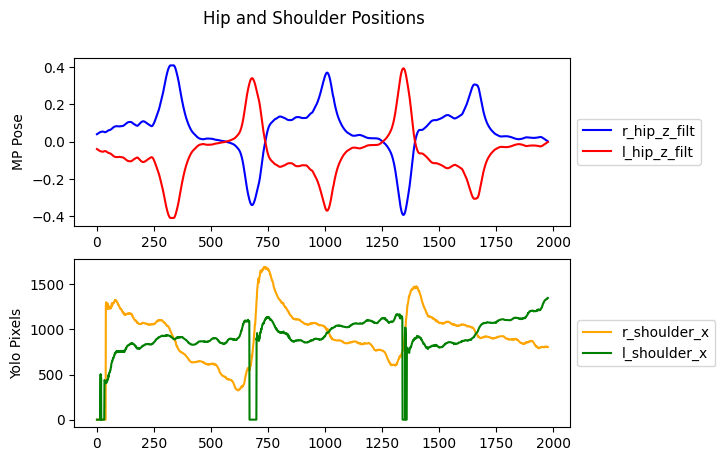

In [10]:
# plots of hip and shoulder positions 

# set plot with two subplots 
fig1, (ax1, ax2) = plt.subplots(2)
fig1.suptitle('Hip and Shoulder Positions')

# subplot 1 - mp z for each hip 
ax1.plot(frames, hip_r_mp_z_filt, label = 'r_hip_z_filt', color = 'blue')
ax1.plot(frames, hip_l_mp_z_filt, label = 'l_hip_z_filt', color = 'red')
ax1.set_ylabel('MP Pose')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# subplot 2 - yolo x for each shoulder 
ax2.plot(frames, shoulder_r_yolo_df['X'], label = 'r_shoulder_x', color = 'orange')
ax2.plot(frames, shoulder_l_yolo_df['X'], label = 'l_shoulder_x', color = 'green')
ax2.set_ylabel('Yolo Pixels')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

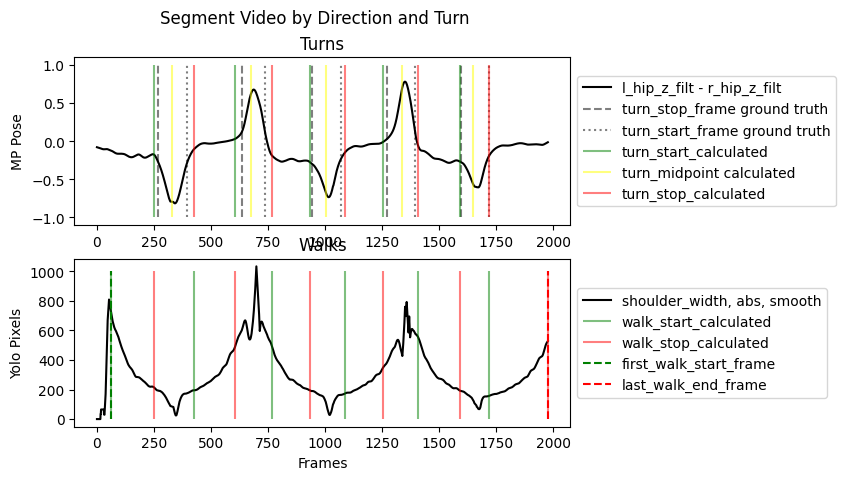

In [57]:
# plot 2 
# set plot with two subplots 
fig2, (ax1, ax2) = plt.subplots(2)
fig2.suptitle('Segment Video by Direction and Turn')

# subplot 1 - distance between right and left hip, use peaks and mins as turns 
ax1.set_title('Turns')
ax1.plot(frames, hip_z_diff_mp_filt, label = 'l_hip_z_filt - r_hip_z_filt', color = 'black')
ax1.vlines(x = ground_truth_turn_frames_df['start_frame'],  ymin = -1, ymax = 1, linestyle = '--', color = 'black', alpha = 0.5, label = 'turn_stop_frame ground truth')
ax1.vlines(x = ground_truth_turn_frames_df['stop_frame'], ymin = -1, ymax = 1, linestyle = 'dotted', color = 'black', alpha = 0.5,label = 'turn_start_frame ground truth')
ax1.vlines(x = turn_start_frames, ymin = -1, ymax = 1, color = 'green', alpha = 0.5, label = 'turn_start_calculated')
ax1.vlines(x=turn_df['turn_midpoint'], ymin = -1, ymax = 1, color = 'yellow',  alpha = 0.5, label = 'turn_midpoint calculated')
ax1.vlines(x = turn_stop_frames, ymin = -1, ymax = 1, color = 'red', alpha = 0.5,  label = 'turn_stop_calculated')
ax1.set_ylabel('MP Pose')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# sublot 2 - yolo shoulder width 
ax2.set_title('Walks')
ax2.plot(frames, shoulder_width_yolo_smooth, label = "shoulder_width, abs, smooth", color = 'black') 
ax2.vlines(x = walks_df['walk_start_frame'], ymin = 0, ymax = 1000, color = 'green', alpha = 0.5, label = 'walk_start_calculated')
ax2.vlines(x = walks_df['walk_end_frame'], ymin = 0, ymax = 1000, color = 'red', alpha = 0.5,  label = 'walk_stop_calculated')
ax2.vlines(x = first_walk_start_frame, ymin = 0, ymax = 1000,  color = 'green', linestyle = '--', label = 'first_walk_start_frame')
ax2.vlines(x = last_walk_end_frame, ymin = 0, ymax = 1000, color = 'red', linestyle = '--', label = 'last_walk_end_frame')
ax2.set_xlabel('Frames')
ax2.set_ylabel('Yolo Pixels')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [65]:
# outputs 
    # save plot 
    # add column - away 1, turn 1, toward 1, away 2 
    # save df (and as .csv) with frames at which events occur (ie - columns: away_1_start, away_1_stop, turn_1 start, turn_1_stop, etc) 
    # save time of each walk, time per turn, etc 

# save number of turns 
data = {'number_of_turns':[len(hip_z_diff_mp_filt_turn_midpoints)]}
num_turns = pd.DataFrame(data)
# save as num_turns .csv 

# save turn_df as .csv 

# save walk_df as .csv 

# save plots
# plot 1 
output_folder = os.path.join(output_parent_folder, '004_segment_towards_away_turn')

if not os.path.exists(output_folder):
        os.makedirs(output_folder)

output_plot_1 = os.path.normpath(os.path.join(output_folder, 'hip_z_mp_shoulder_x_yolo.png'))
fig1.savefig(output_plot_1, bbox_inches = 'tight')

# plot 2 
output_plot_2 = os.path.normpath(os.path.join(output_folder, 'turn_walk_start_stop.png'))
fig2.savefig(output_plot_2, bbox_inches = 'tight')